In [3]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [17]:
X = np.random.permutation(np.load("mnist.npy"))/255

In [41]:
def VAE(X,k,n_dim, learning_rate = 0.01):
  
    X_ = tf.contrib.layers.flatten(X)
    hidden_1 = tf.layers.dense(X_, units = 512, activation = tf.nn.relu)
    
    mean = tf.layers.dense(hidden_1, k)
    s = tf.layers.dense(hidden_1, k)
    
    epsilon = tf.random_normal(tf.shape(mean))
    latent_vec = mean + tf.exp(s/2)*epsilon
    outputs = tf.layers.dense(latent_vec, n_dim**2)
    outputs_sigmoid = tf.sigmoid(outputs)
    final_outputs = tf.reshape(outputs, [-1,n_dim,n_dim])

    xen_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels = X_, logits = outputs))
    loss_usual = 0.5*tf.reduce_sum(tf.square(mean) + tf.exp(s) - s)

    loss = xen_loss + loss_usual
    loss_control = tf.reduce_mean(tf.square(final_outputs - X))
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)

    
    return train, final_outputs, loss, latent_vec
    
def train_VAE(X_data, epochs = 15, learning_rate= 0.01, batch = 40, k = 2, visualize = True, interpolate = True, render_normal = True):
    
    X_tr, X_val = train_test_split(X_data,test_size = 0.1)
    n_trn, n_dim = X_tr.shape[0], X_tr.shape[1]
    
    with tf.Graph().as_default():
        training = tf.placeholder(tf.bool)
        X = tf.placeholder(tf.float32, [None, n_dim, n_dim], name="X")
        
        train, final_outputs, loss, mean = VAE(X, k, n_dim, learning_rate)
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            sess.run(init)
            for i in range(epochs):
                perms = np.array_split(np.random.permutation(n_trn),n_trn/batch)
                for perm in perms:
                    train.run(feed_dict={X: X_tr[perm]})
                    loss_tr = loss.eval(feed_dict={X: X_tr[perm]})
                    
                loss_val = loss.eval(feed_dict={X: X_val})
                print("Epoch = ",i ," loss train = ", loss_tr," loss val = ", loss_val)
              
            if visualize == True:
                
                images = []
                images.append(final_outputs.eval(feed_dict={X : X_tr[:10]}))
                images.append(final_outputs.eval(feed_dict={X : X_val[:10]}))
                images.append(X_tr[:10])
                images.append(X_val[:10])
                
                for (ind,im) in enumerate(images):
                    plt.figure(figsize=(20,10))
                    for i in range(10):
                        plt.subplot(2,5,i+1)
                        plt.imshow(im[i])
                    
                    print "10 First " + (ind == 0)*"train" + (ind == 1)*"val"+ (ind == 2)*"real train" + (ind == 3)*"real val" + " images, k ="+str(k)
                    plt.show()
            
            if interpolate == True:
                
                codes = []
                codes.append(mean.eval(feed_dict={X : X_tr[:10]}))
                codes.append(mean.eval(feed_dict={X : X_val[:10]}))
                print "Interpolation"
                for i in range(10):
                    plt.figure(figsize=(20,10))
                    for j in range(10):
                        code_inter = codes[0][i] + (j/9)*(codes[1][i] - codes[0][i])
                        image = final_outputs.eval(feed_dict={mean: np.expand_dims(code_inter,0)})
                        plt.subplot(2,5,j+1)
                        plt.imshow(image[0])
                    plt.show()
        
            if render_normal == True:
                
                codes = np.random.normal(size = [10,k])
                images = final_outputs.eval(feed_dict = {mean: codes})
                print "Sampling from standard Gaussian"
                plt.figure(figsize=(20,10))
                for i in range(10):
                    plt.subplot(2,5,i+1)
                    plt.imshow(images[i])
                plt.show()

('Epoch = ', 0, ' loss train = ', 7520.71, ' loss val = ', 1130594.0)
('Epoch = ', 1, ' loss train = ', 7806.7178, ' loss val = ', 1129438.9)
('Epoch = ', 2, ' loss train = ', 7551.0146, ' loss val = ', 1110088.5)
('Epoch = ', 3, ' loss train = ', 6994.5107, ' loss val = ', 1118684.0)
('Epoch = ', 4, ' loss train = ', 7457.1514, ' loss val = ', 1107702.2)
('Epoch = ', 5, ' loss train = ', 7271.7036, ' loss val = ', 1112015.2)
('Epoch = ', 6, ' loss train = ', 7323.0952, ' loss val = ', 1107859.4)
('Epoch = ', 7, ' loss train = ', 7495.9917, ' loss val = ', 1101941.6)
('Epoch = ', 8, ' loss train = ', 7837.7505, ' loss val = ', 1099478.9)
('Epoch = ', 9, ' loss train = ', 7192.498, ' loss val = ', 1100625.4)
('Epoch = ', 10, ' loss train = ', 7160.7129, ' loss val = ', 1092022.5)
('Epoch = ', 11, ' loss train = ', 7202.2744, ' loss val = ', 1103853.5)
('Epoch = ', 12, ' loss train = ', 7094.4629, ' loss val = ', 1093348.0)
('Epoch = ', 13, ' loss train = ', 7735.7856, ' loss val = ', 11

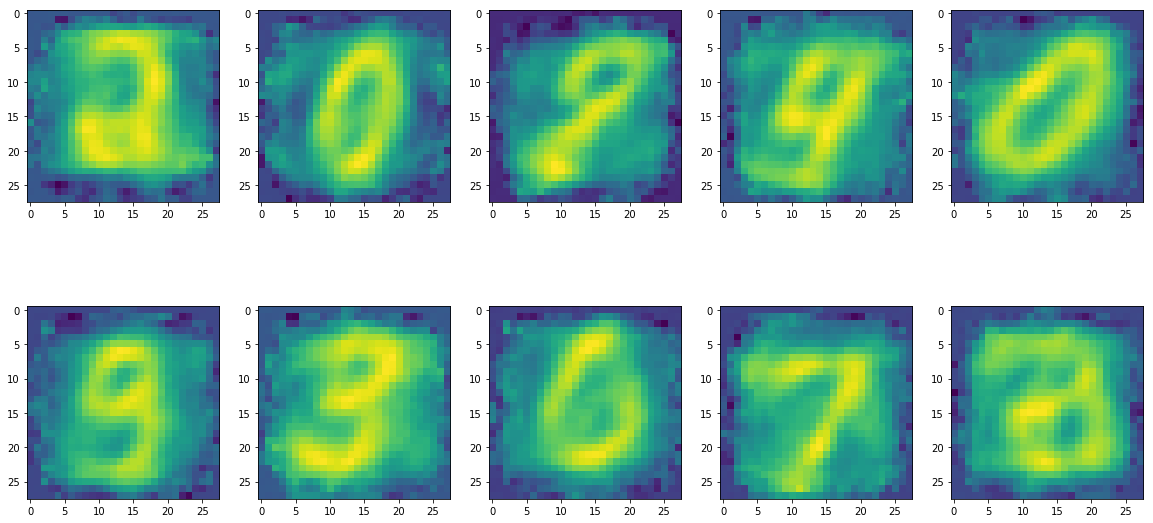

10 First val images, k =100


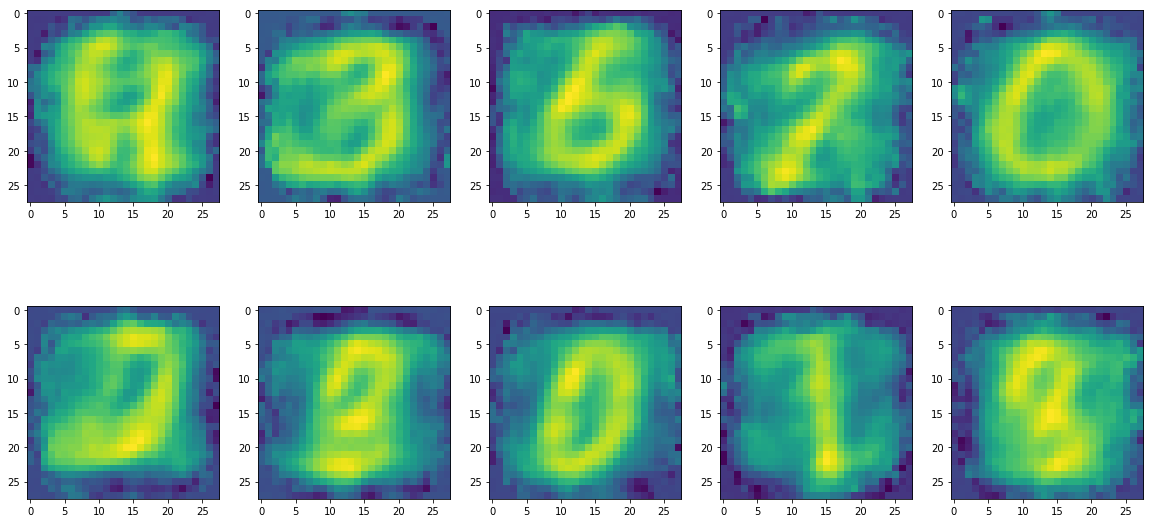

10 First real train images, k =100


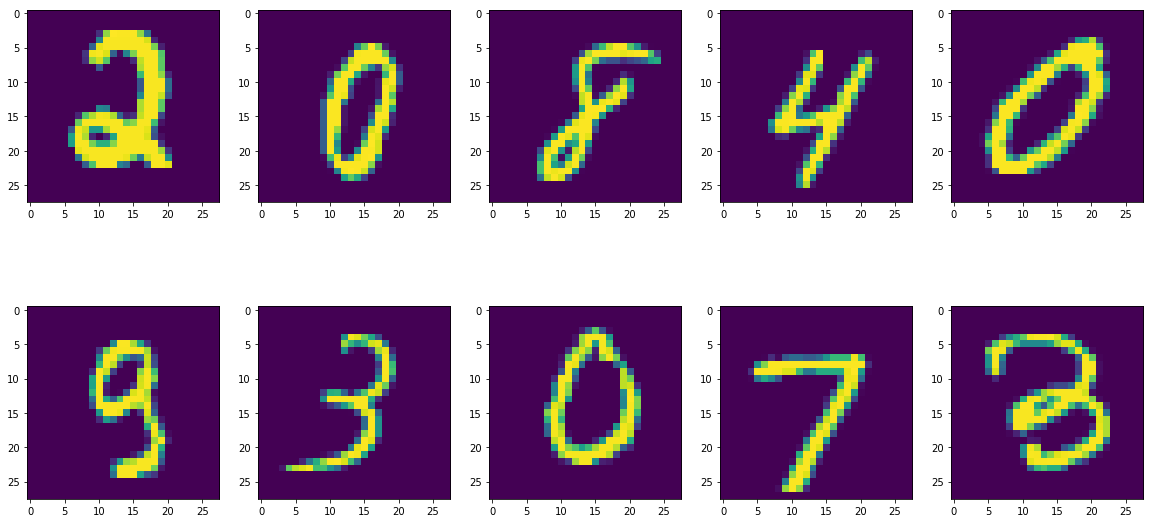

10 First real val images, k =100


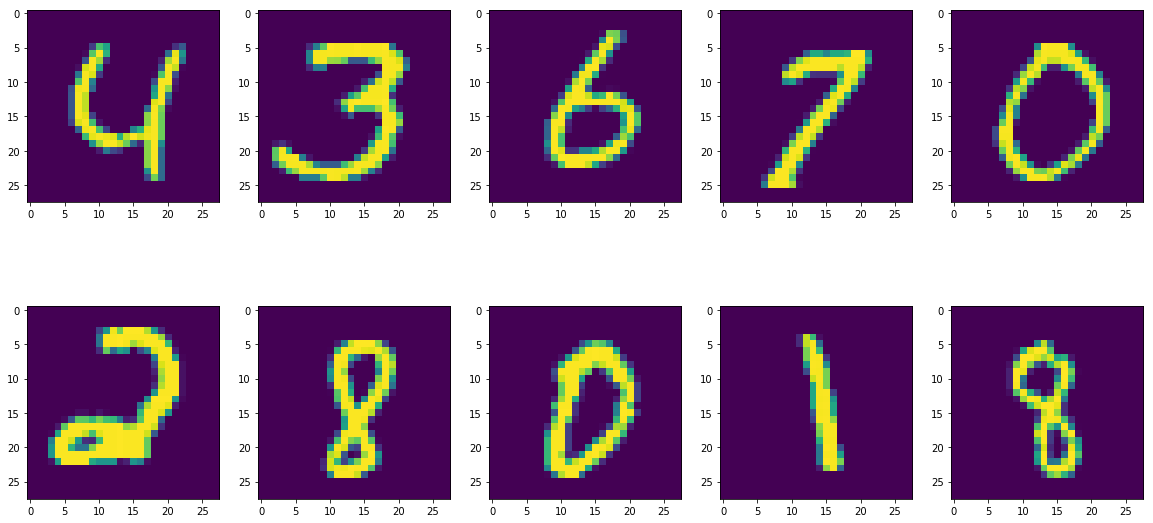

Interpolation


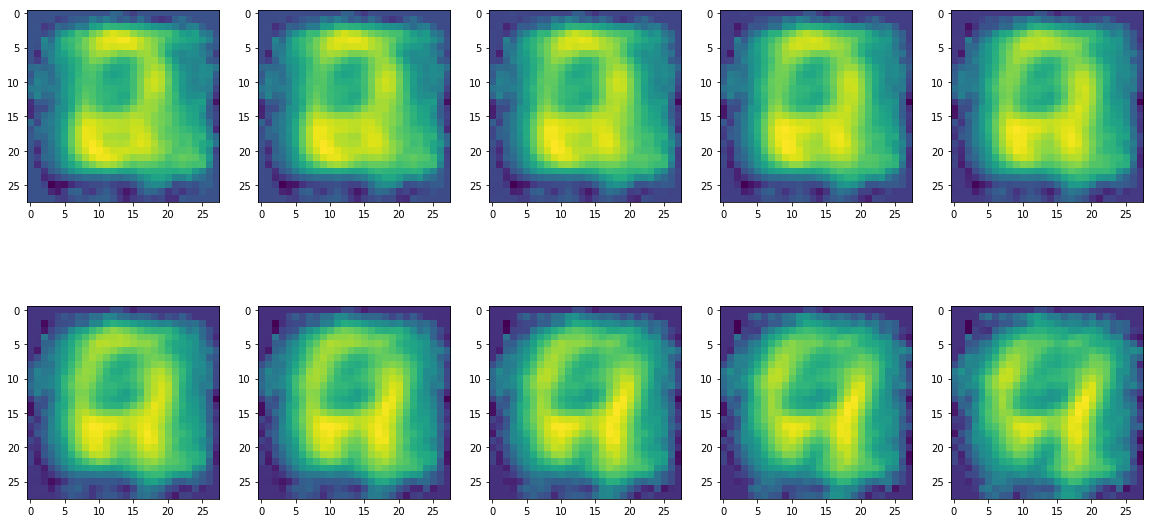

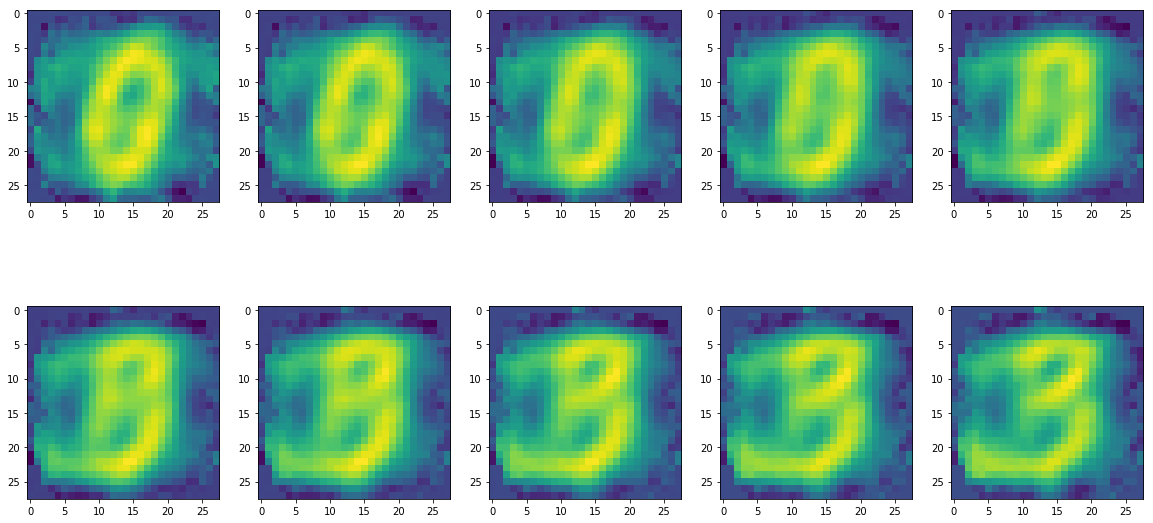

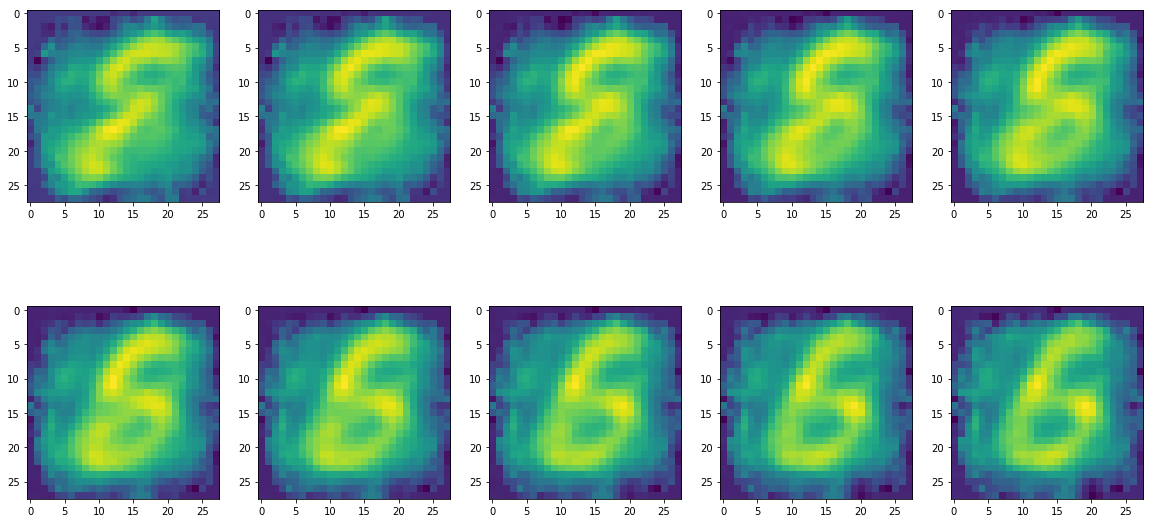

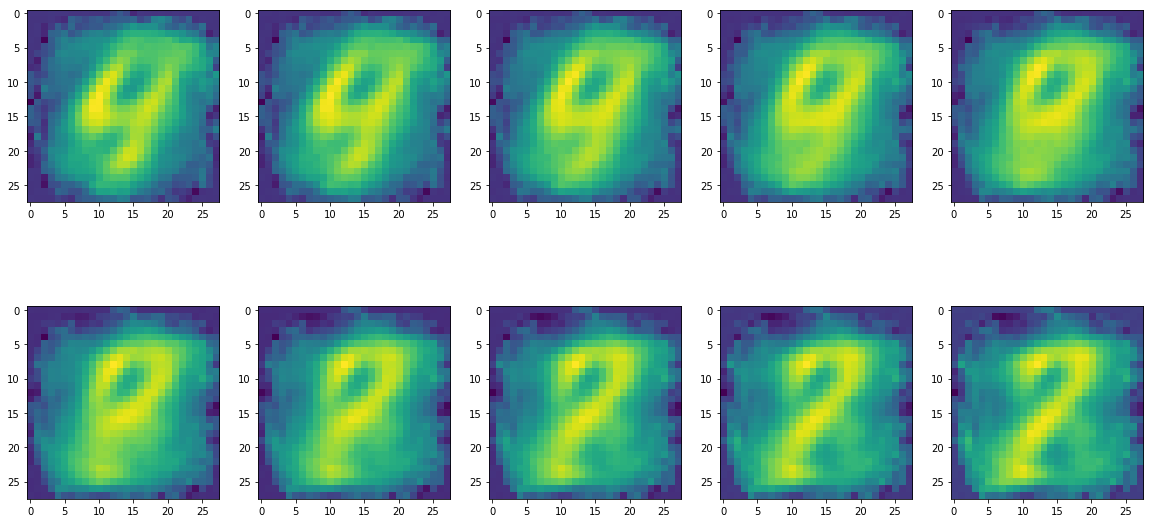

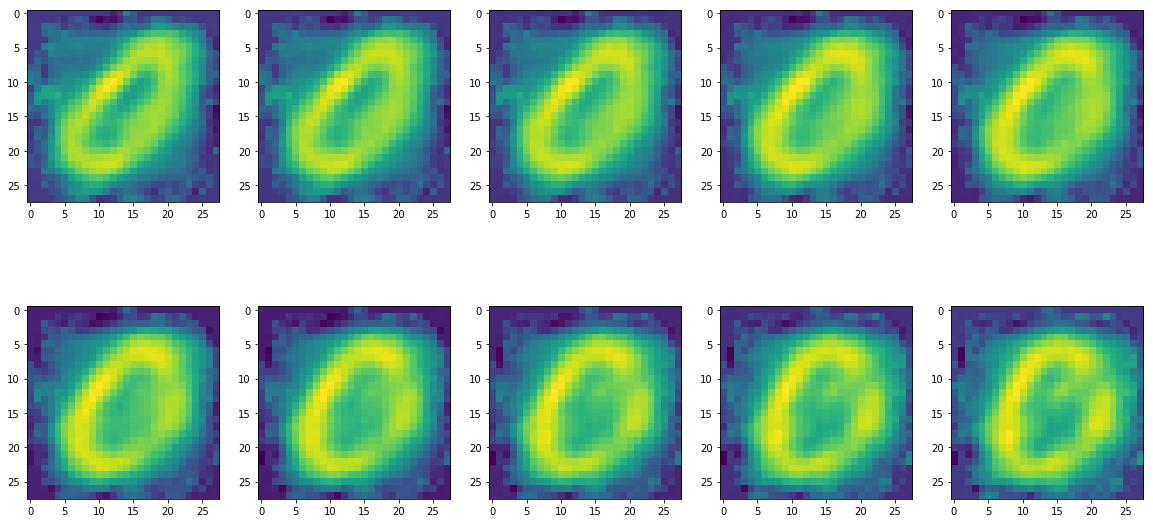

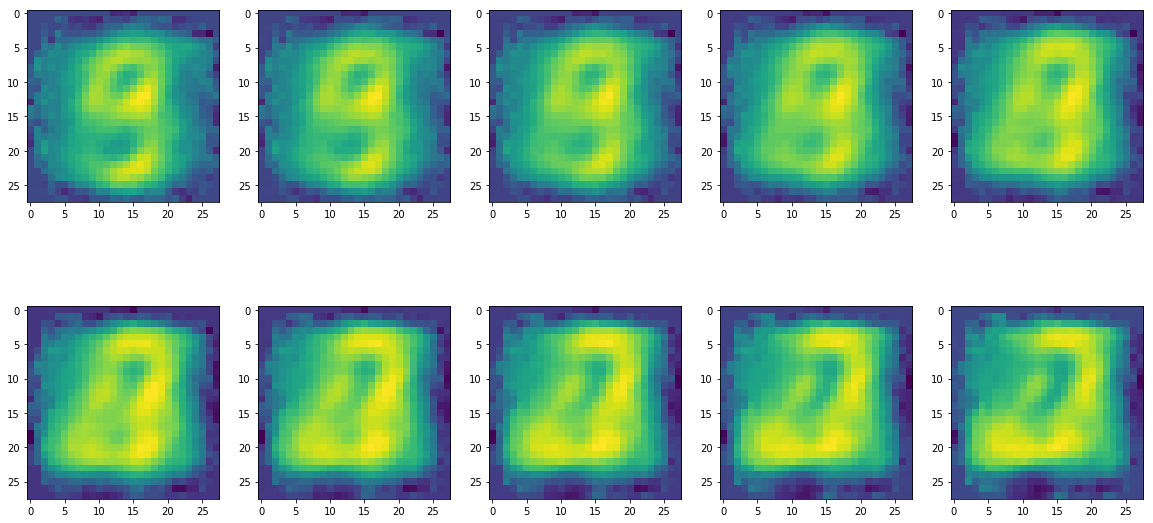

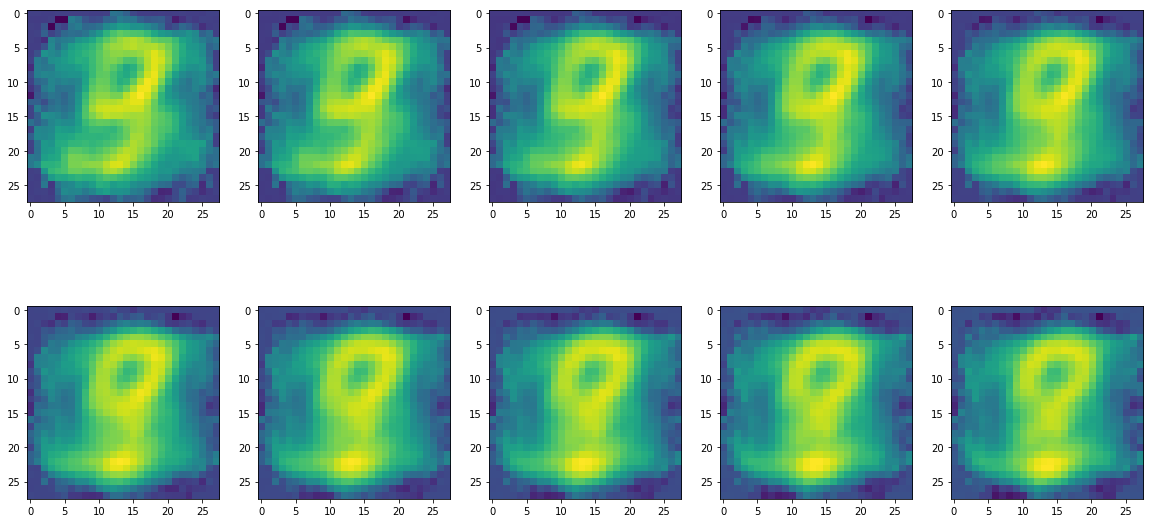

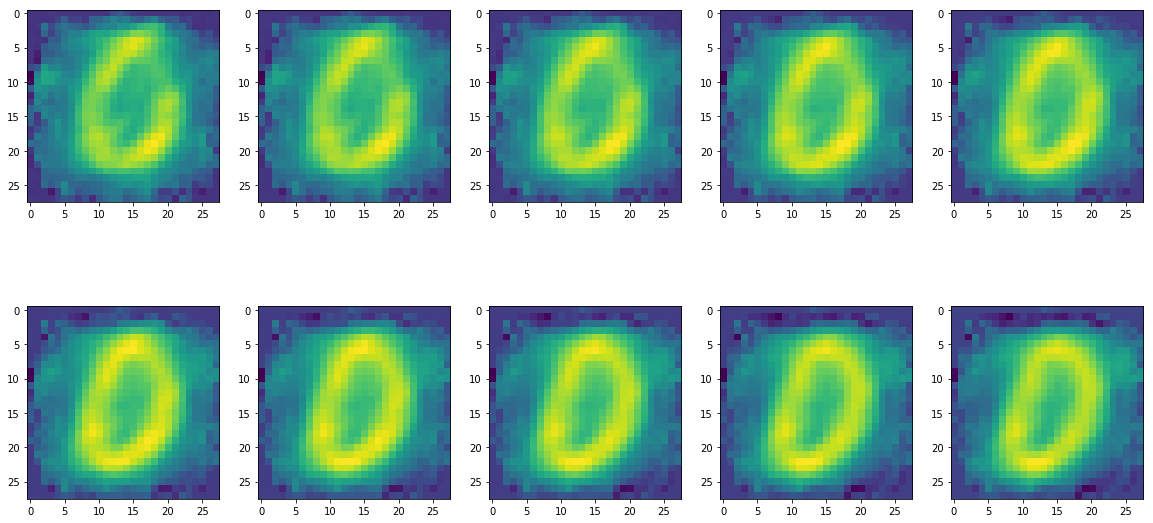

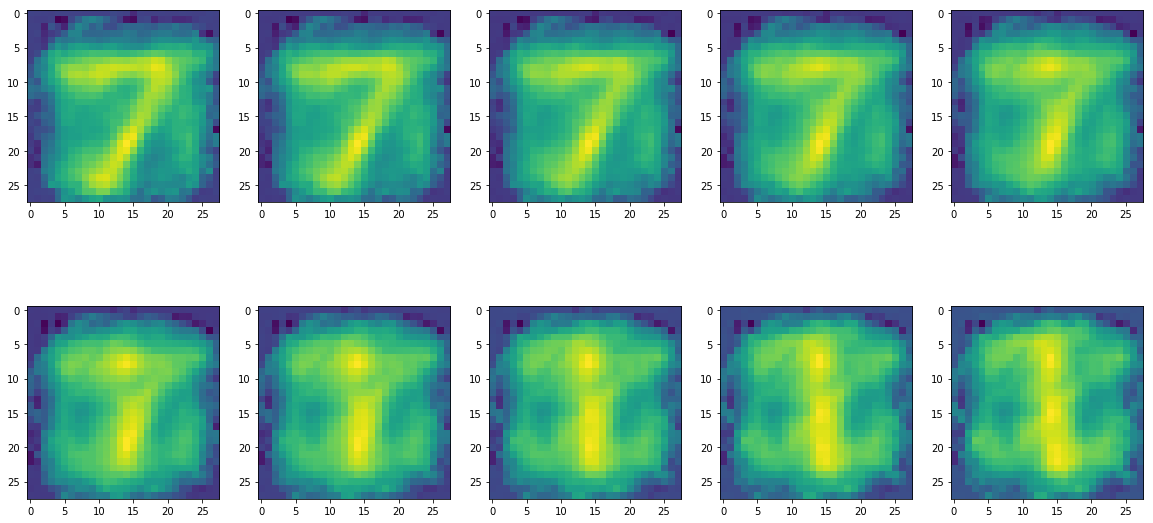

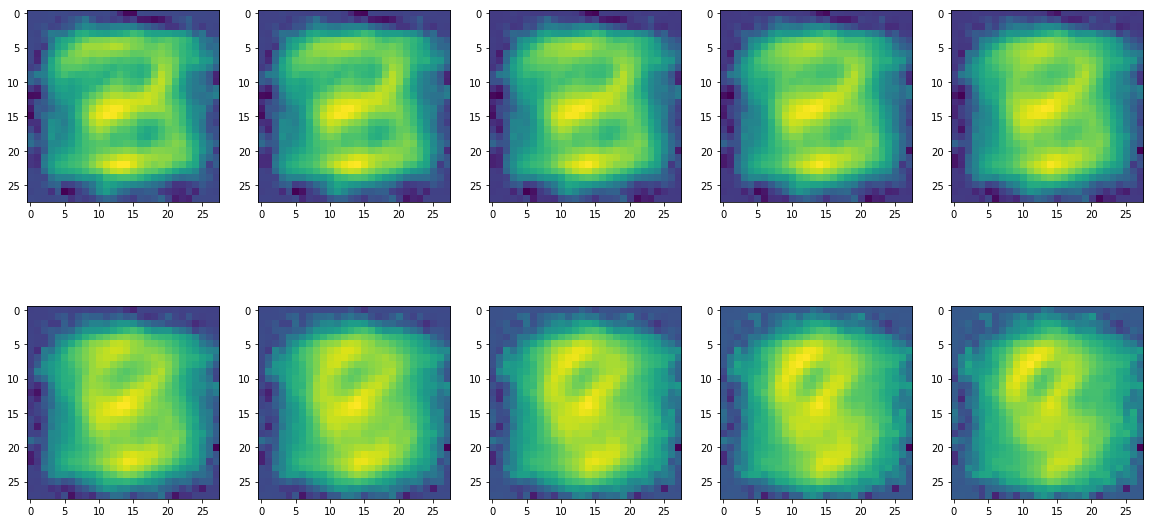

Sampling from standard Gaussian


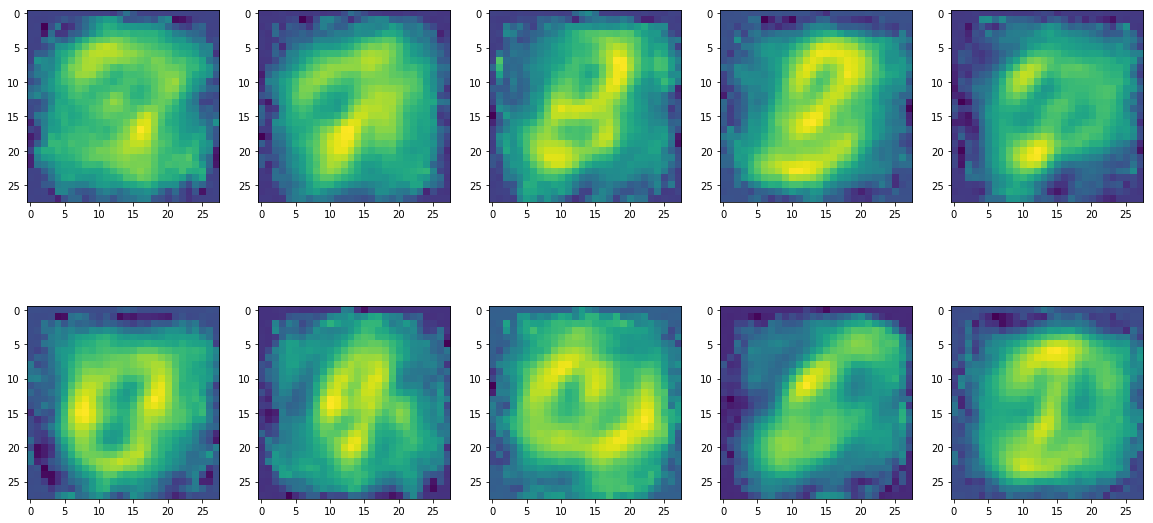

In [42]:
train_VAE(X, k = 100)